In [186]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time

from helper_functions import save_figure
from settings import paths

In [11]:
epoch_folder = paths['epochs_folder']
plot_folder = paths['plots_folder']

In [12]:
bad_chans = {
    "80630": ["OFC_R"],
    "39489": ["OFC_R"],
    "80625": ["OFC_L"],
    "81193": ["OFC_R", "OFC_L"]
}

In [13]:
freq_bands = {
    'Delta': (2, 4), 
    'Theta': (4, 8), 
    'Alpha': (8, 13), 
    'Beta': (13, 30), 
    'Gamma': (30, 100)
}

Import the epoch file and drop unwanted EMG channels

In [14]:
filtered_epochs = mne.read_epochs(os.path.join(epoch_folder, "filtered_epochs_w_movement-epo.fif"), preload=True)
filtered_epochs.drop_channels(['EMG_L', 'EMG_R'])

Number of events,28243
Events,1: 28243
Time range,0.000 – 4.999 s
Baseline,off


We want to investigate differences between resting and non-resting, so let's split the epochs on this behaviour using the metadata

In [15]:
movement_epochs = filtered_epochs[filtered_epochs.metadata["movement"] == 1]
non_movement_epochs = filtered_epochs[filtered_epochs.metadata["movement"] == 0]

### General functions

Let's create a function that takes a connectivity measure method as an argument and computes it

In [38]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose=False, gc_n_lags=40)
    return con.get_data(output='dense')

And now a general function that allows us to generate a connectivity measure dataframe for a given measure. Note that we omit the channel-channel connectivity measures for the 'low qaulity' channels that are manually entered into the *bad_chans* dictionary defined above.

In [39]:
def connectivity_df(epochs, method):
    results_df = pd.DataFrame()
    subject_ids = epochs.metadata['animal_id'].unique()

    # per subject, calculate the given measure for all epochs
    for idx, subject_id in enumerate(subject_ids):
        # subset of the data for this subject
        mouse_epochs = epochs[epochs.metadata['animal_id']==subject_id].copy()
        genotype = mouse_epochs.metadata['genotype'].unique()[0]
    
        # compute the given connectivity measure for every frequency band
        for band_name, (fmin, fmax) in freq_bands.items():
            # compute the connectivity using the provided method
            con = compute_con(mouse_epochs, method, fmin, fmax)
            
            # loop through first channel of connectivity pair
            for i in range(con.shape[1]):
                # loop through second channel of connectivity pair
                for j in range(i+1, con.shape[0]):
                    # if looped channel for this subject in bad channel dict, skip it
                    if subject_id in bad_chans.keys():
                        if epochs.ch_names[i] in bad_chans[subject_id] or epochs.ch_names[j] in bad_chans[subject_id]:
                            continue
                    # add the data
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'con' : con[j, i, 0],
                        'node1' : epochs.ch_names[i],
                        'node2' : epochs.ch_names[j],
                        'band' : band_name,
                        'subject_id': subject_id,
                        'genotype': genotype
                    }, index=[0])], ignore_index=True)
                    
    return results_df

And a function which allows us to generate neat heatmaps of a given connectivity measure

In [40]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Now, let's create a function that generates a grid that holds a subplot per frequency band and genotype.

In [84]:
def generate_grid_plot(data, method, behaviour, cmap='flare'):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    freq_band_names = freq_bands.keys()
    genotypes = data['genotype'].unique()
    
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        # make a subplot for every band of each genotype
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"mov_vs_non_mov/connectivity/{method}_grid_{behaviour}.pdf"))

### Connectivity: Coherence

Let's first get the coherence

In [74]:
coh_movement = connectivity_df(movement_epochs, "coh")
generate_grid_plot(coh_movement, 'coh', "Movement")

In [76]:
coh_non_movement = connectivity_df(non_movement_epochs, "coh")
generate_grid_plot(coh_non_movement, 'coh', "Non-movement")

### Phase Lag Index (PLI)

* For PLI, means that signal leads and lags signal equally often, while a value greater than means that there is an imbalance in the likelihood for signal to be leading or lagging. A value of means that signal only leads or only lags signal.
*
* For wPLI, means that the total weight (not the quantity) of all leading relationships equals the total weight of lagging relationships, while a value greater than means that there is an imbalance between these weights. A value of, just as in PLI, means that signal only leads or only lags signal.
*
* With dPLI, we gain the ability to distinguish whether signal is leading or lagging signal, complementing the information provided by PLI or wPLI. A value of  means that signal leads and lags signal equally often. A value in the range means that signal leads signal  more often than it lags, with a value of meaning that signal always leads signal. A value in the range means that signal lags signal more often than it leads, with a value of meaning that signal always lags signal. The PLI can actually be extracted from the dPLI by the relationship, but this relationship is not invertible (dPLI can not be estimated from the PLI).

#### Regular PLI

In [78]:
pli_movement = connectivity_df(movement_epochs, "pli")
generate_grid_plot(pli_movement, 'pli', "Movement")

In [79]:
pli_non_movement = connectivity_df(non_movement_epochs, "pli")
generate_grid_plot(pli_non_movement, 'pli', "Non-movement")

#### Directed PLI (DPLI)

In [80]:
dpli_movement = connectivity_df(movement_epochs, "dpli")
generate_grid_plot(dpli_movement, 'dpli', "Movement")

In [81]:
dpli_non_movement = connectivity_df(non_movement_epochs, "dpli")
generate_grid_plot(dpli_non_movement, 'dpli', "Non-movement")

#### Weighted PLI (WPLI)

In [82]:
wpli_movement = connectivity_df(movement_epochs, "wpli")
generate_grid_plot(wpli_movement, 'wpli', "Movement")

In [83]:
wpli_non_movement = connectivity_df(non_movement_epochs, "wpli")
generate_grid_plot(wpli_non_movement, 'wpli', "Non-movement")

#### WPLI2 debiased

In [85]:
wpli2_movement = connectivity_df(movement_epochs, "wpli2_debiased")
generate_grid_plot(wpli2_movement, 'wpli2_debiased', "Movement")

In [86]:
wpli2_non_movement = connectivity_df(non_movement_epochs, "wpli2_debiased")
generate_grid_plot(wpli2_non_movement, 'wpli2_debiased', "Non-movement")

## Barplotting

Let's define a general function that takes our pre-generated dataframes holding the connectivity measure data, and generates a barplot per unique channel combination (hue on genotype).

But first, we need all unique channel combinations for the purpose of uniformal plotting

In [150]:
combinations = coh_movement['node1'] + '-' + coh_movement['node2']
unique_combinations = combinations.unique()

In [160]:
def generate_barplots(data, method, behaviour):
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True)
    axs = axs.ravel()
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({behaviour} / {method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"mov_vs_non_mov/connectivity/barplots/{method}_grid_{behaviour}.pdf"))

Let's generate the figures for all data

In [161]:
generate_barplots(wpli_movement, "wpli", "Movement")
generate_barplots(wpli_non_movement, "wpli", "Non-movement")

In [162]:
generate_barplots(coh_movement, "coh", "Movement")
generate_barplots(coh_non_movement, "coh", "Non-movement")

In [163]:
generate_barplots(pli_movement, "pli", "Movement")
generate_barplots(pli_non_movement, "pli", "Non-movement")

In [164]:
generate_barplots(dpli_movement, "dpli", "Movement")
generate_barplots(dpli_non_movement, "dpli", "Non-movement")

In [165]:
generate_barplots(wpli2_movement, "wpli2_debiased", "Movement")
generate_barplots(wpli2_non_movement, "wpli2_debiased", "Non-movement")

Let's create figures where the WT and KO movement is compared to the non-movement

In [166]:
def generate_barplots_mov_vs_non_mov(method, movement_data, non_movement_data, genotype):
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    # combine the data of both behaviours
    ss1 = movement_data[movement_data['genotype'] == genotype]
    ss2 = non_movement_data[non_movement_data['genotype'] == genotype]
    ss1["behaviour"] = "Movement"
    ss2["behaviour"] = "Non-movement"
    concatted = pd.concat([ss1, ss2])
    
    for i, combination in enumerate(unique_combinations):
        chan1, chan2 = combination.split('-')
        data_subset = concatted[(concatted['node1'] == chan1) & (concatted['node2'] == chan2)]
        
        sns.barplot(data=data_subset, x="band", y="con", hue="behaviour", hue_order=["Movement", "Non-movement"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="behaviour", hue_order=["Movement", "Non-movement"], palette='dark:black', alpha=0.4, legend=None, dodge=True, ax=axs[i])
        
        axs[i].set_title(f"Movement vs Non-movement: {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"mov_vs_non_mov/connectivity/barplots/mov_vs_non_mov/{method.upper()}_{genotype}.png"))

Let's run it for the WT subjects

In [167]:
generate_barplots_mov_vs_non_mov(method='coh', movement_data=coh_movement, non_movement_data=coh_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='pli', movement_data=pli_movement, non_movement_data=pli_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='dpli', movement_data=dpli_movement, non_movement_data=dpli_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='wpli', movement_data=wpli_movement, non_movement_data=wpli_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='wpli2_debiased', movement_data=wpli2_movement, non_movement_data=wpli2_non_movement, genotype="DRD2-WT")

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss1["behaviour"] = "Movement"
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss2["behaviour"] = "Non-movement"
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

And for the KO subjects

In [168]:
generate_barplots_mov_vs_non_mov(method='coh', movement_data=coh_movement, non_movement_data=coh_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='pli', movement_data=pli_movement, non_movement_data=pli_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='dpli', movement_data=dpli_movement, non_movement_data=dpli_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='wpli', movement_data=wpli_movement, non_movement_data=wpli_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='wpli2_debiased', movement_data=wpli2_movement, non_movement_data=wpli2_non_movement, genotype="DRD2-KO")

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss1["behaviour"] = "Movement"
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss2["behaviour"] = "Non-movement"
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_2712/3027015320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

#### Investigation of good/bad epoch distribution
spectral_connectivity_epochs vs spectral_connectivity_time 

In [ ]:
epochs_81207_bad = mne.read_epochs("/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/resting_state/output/epochs/filtered_epochs_resting_state_81207-epo.fif", preload=True)

In [230]:
epochs_79593_good = mne.read_epochs("/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/resting_state/output/epochs/filtered_epochs_resting_state_79593-epo.fif", preload=True)

In [228]:
freqs = np.arange(1, 4, .5)  # Example frequency range from 7 to 30 Hz with a step of 2 Hz

con = spectral_connectivity_time(
    epochs_81207_bad.get_data(picks=["OFC_R", "OFC_L"]), freqs, method="wpli", mode='multitaper', sfreq=epochs_81207_bad.info['sfreq'],
    fmin=0, fmax=100, faverage=True, verbose=False, n_cycles=freqs, n_jobs=-1
)
dat_81207_bad = con.get_data(output='dense')

/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/mne_connectivity/spectral/time.py:1180: RuntimeWarning: invalid value encountered in divide
  wpli = con_num / con_den


In [238]:
freqs = np.arange(1, 4, .5)  # Example frequency range from 7 to 30 Hz with a step of 2 Hz

con = spectral_connectivity_time(
    epochs_79593_good.get_data(picks=["OFC_R", "OFC_L"]), freqs, method="wpli", mode='multitaper', sfreq=epochs_79593_good.info['sfreq'],
    fmin=0, fmax=100, faverage=True, verbose=False, n_cycles=freqs, n_jobs=-1
)
dat_79593_good = con.get_data(output='dense')

/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/mne_connectivity/spectral/time.py:1180: RuntimeWarning: invalid value encountered in divide
  wpli = con_num / con_den


In [260]:
np.mean(dat_81207_bad[:-1, 1, 0, 0]), np.mean(dat_79593_good[:-1, 1, 0, 0])

(0.7794653392317148, 0.7052075034105866)

<Axes: ylabel='Count'>

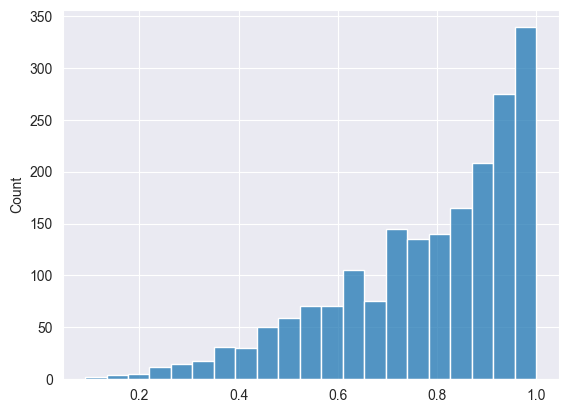

In [237]:
sns.histplot(dat_81207_bad[:, 1, 0, 0])

<Axes: ylabel='Count'>

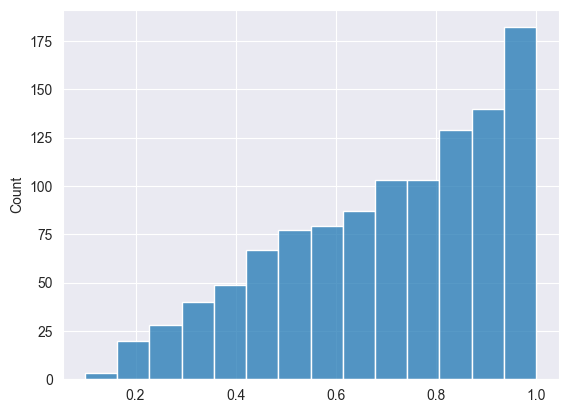

In [251]:
sns.histplot(dat_79593_good[:, 1, 0, 0])